# R3 pituitary

Appears to be the anterior lobe and marginal zone regions only; no genes seem to be expressed in what would be the proximal lobe region. No detectable DAPI (although we do expect a [fainter DAPI](https://pmc.ncbi.nlm.nih.gov/articles/PMC5755434/)) 

Female mouse #897

In [1]:
region = 'R3'

# Import packages

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
from scipy import sparse
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


# Functions

In [3]:
def plot_knee_curve(adata):
    """
    Plot a single knee curve (UMI counts per barcode) for the entire dataset.
    """
    umi_counts = np.array(adata.X.sum(axis=1)).flatten()
    umi_counts.sort()
    umi_counts = umi_counts[::-1]  # descending

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.loglog(range(1, len(umi_counts) + 1), umi_counts, linewidth=2, color="black")

    ax.set_xlabel("Barcodes", fontsize=14)
    ax.set_ylabel("UMI Counts", fontsize=14)
    ax.axhline(y=500, linewidth=1.5, color="#505050", linestyle='--', label='500 UMI')
    ax.axhline(y=200, linewidth=1.5, color="#A0A0A0", linestyle='--', label='200 UMI')

    ax.legend(fontsize=12)
    ax.grid(True, which="both", linestyle=':', linewidth=0.5)
    ax.set_title("Knee Plot", fontsize=16)
    plt.tight_layout()
    plt.show()


# Load Anndata

In [4]:
adata = sq.read.vizgen(
    path=f"pilot_data/region_{region}/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv",
    library_id=f'pilot_{region}'
)

adata.layers["counts"] = adata.X.copy()
adata.obs['region'] = region

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)


In [6]:
adata

AnnData object with n_obs × n_vars = 9437 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

# QC plots

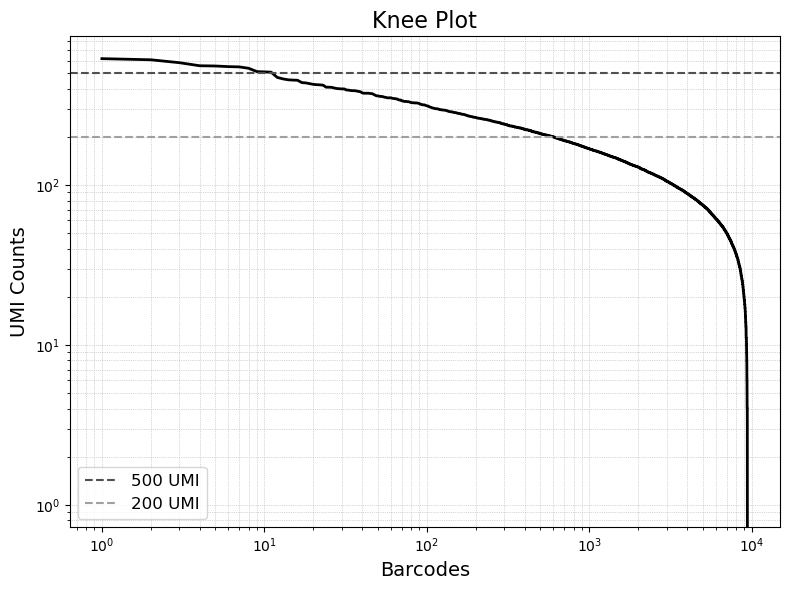

In [7]:
plot_knee_curve(adata)


<Axes: >

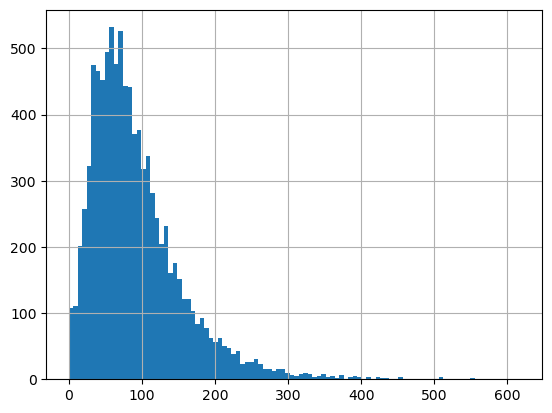

In [8]:
ser_exp = adata.to_df().sum(axis=1)
ser_exp.hist(bins=100)


<Axes: >

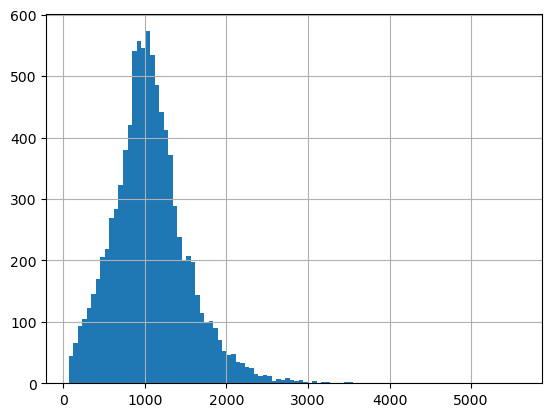

In [9]:
ser_volume = adata.obs['volume']
ser_volume.hist(bins=100)

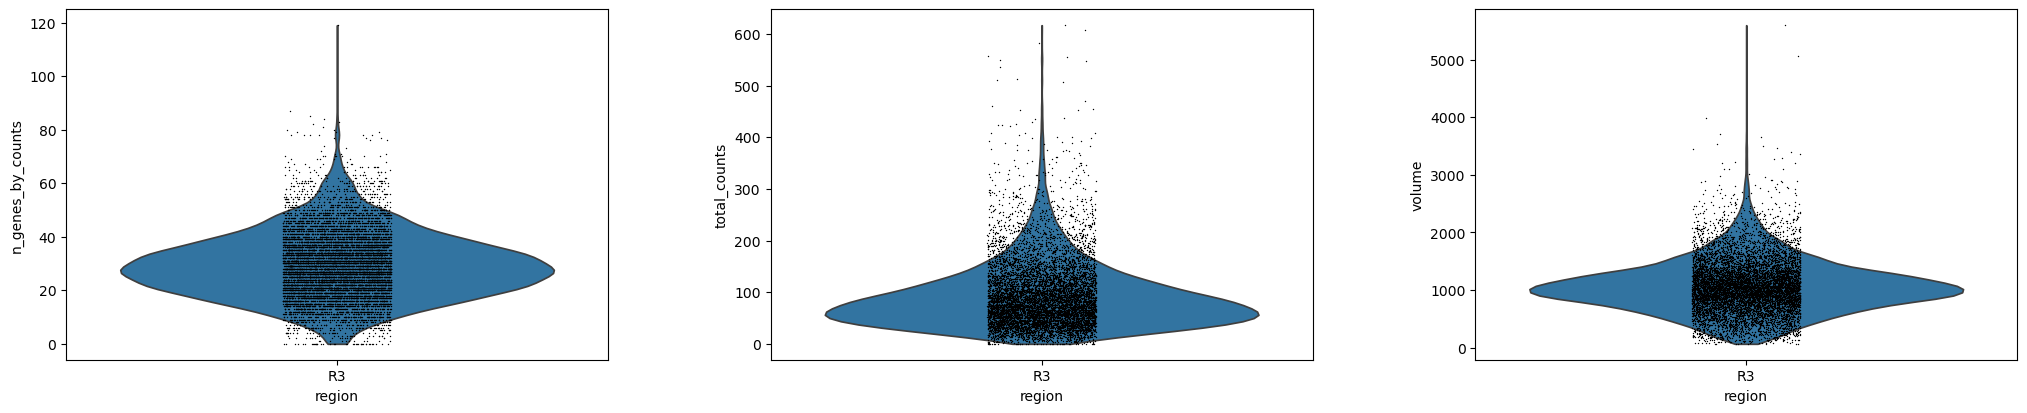

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "volume"],
    groupby="region",
    multi_panel = True
)

# Filter by volume and counts

Both low and high

In [11]:
vol = adata.obs["volume"]
median_volume = np.median(vol)
volume_filter = (vol >= 100) & (vol <= 3 * median_volume)
adata = adata[volume_filter].copy()

# Remove cells with total RNA in top/bottom 1%
total_counts = adata.obs['total_counts']
lower = np.percentile(total_counts, 1)
upper = np.percentile(total_counts, 99)
in_range = (total_counts >= lower) & (total_counts <= upper)
adata = adata[in_range].copy()


In [12]:
adata.obs['total_counts'].min()


7.0

In [13]:
adata.write_h5ad(f"pilot_data/region_{region}/region_{region}_adata_filt.h5ad")

In [14]:
# python3 run_scrublet.py -r R3

In [15]:
adata = sc.read_h5ad(f"pilot_data/region_{region}/region_{region}_adata_filt_scrublet.h5ad")
adata.obs['region'] = region
coords = adata.obsm["spatial"].copy()

# Get bounds to orient around image size
max_x, max_y = coords[:, 0].max(), coords[:, 1].max()

# Rotate 90° CCW: (x, y) → (max_y - y, x)
rotated_coords = np.column_stack([
    max_y - coords[:, 1],
    coords[:, 0]
])

adata.obsm["spatial"] = rotated_coords


In [16]:
adata

AnnData object with n_obs × n_vars = 9205 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'region_colors', 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

# Correlation of cell volume and counts

# Normalize and filter by doublet score

https://www.nature.com/articles/s41586-023-06808-9

In [17]:
# normalize counts by volume
inv_volumes = 1 / adata.obs["volume"].values # scaling factor 
inv_vol_diag = sparse.diags(inv_volumes)
adata.layers["counts_volume_norm"] = inv_vol_diag @ adata.layers["counts"]

# scale
total_counts = np.array(adata.layers["counts_volume_norm"].sum(axis=1)).flatten()
scale_factor = 250 / np.mean(total_counts)

adata.layers["counts_volume_norm_scaled"] = adata.layers["counts_volume_norm"] * scale_factor

adata = adata[adata.obs["doublet_score"] <= 0.25].copy()


In [18]:
adata

AnnData object with n_obs × n_vars = 9194 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'region_colors', 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts', 'counts_volume_norm', 'counts_volume_norm_scaled'

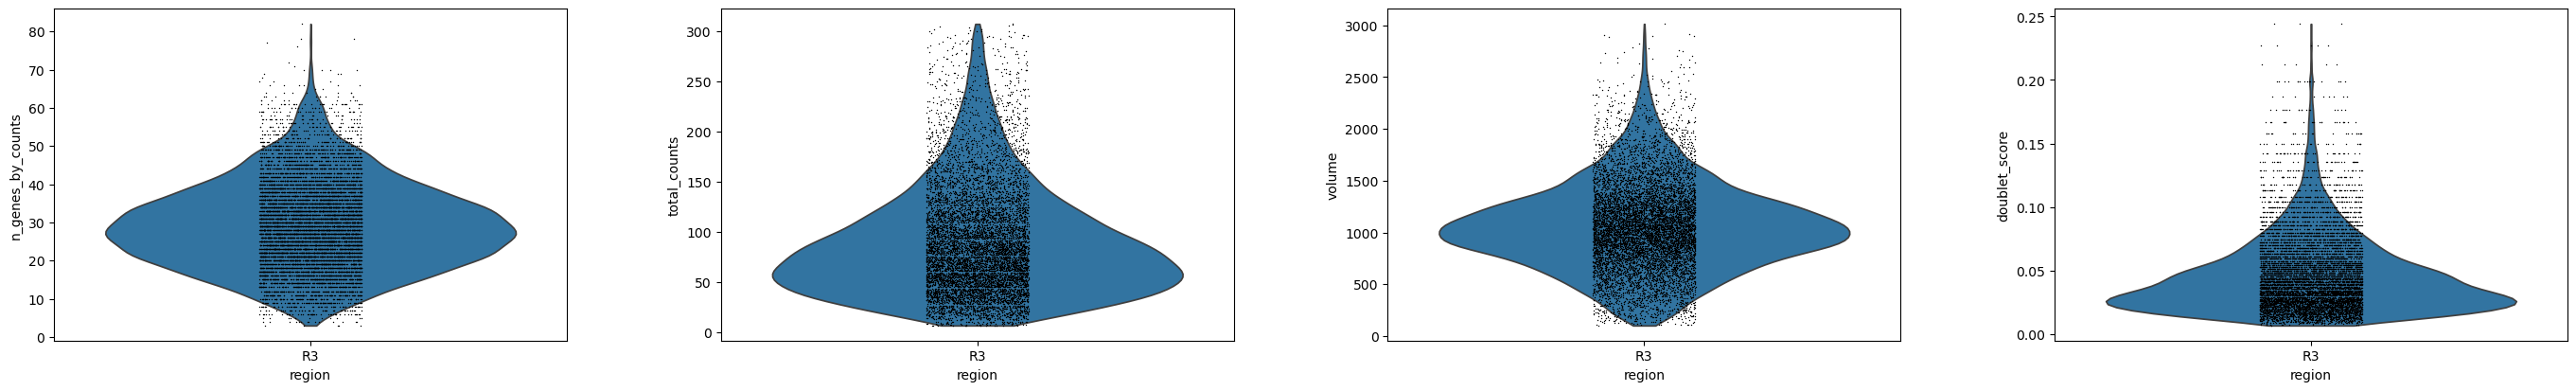

In [19]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "volume", "doublet_score"],
    groupby="region",
    multi_panel = True
)

# Log normalization, PCA, clustering, UMAP

In [20]:
adata.X = adata.layers['counts_volume_norm_scaled'].copy()

In [21]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
# sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution = 2)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


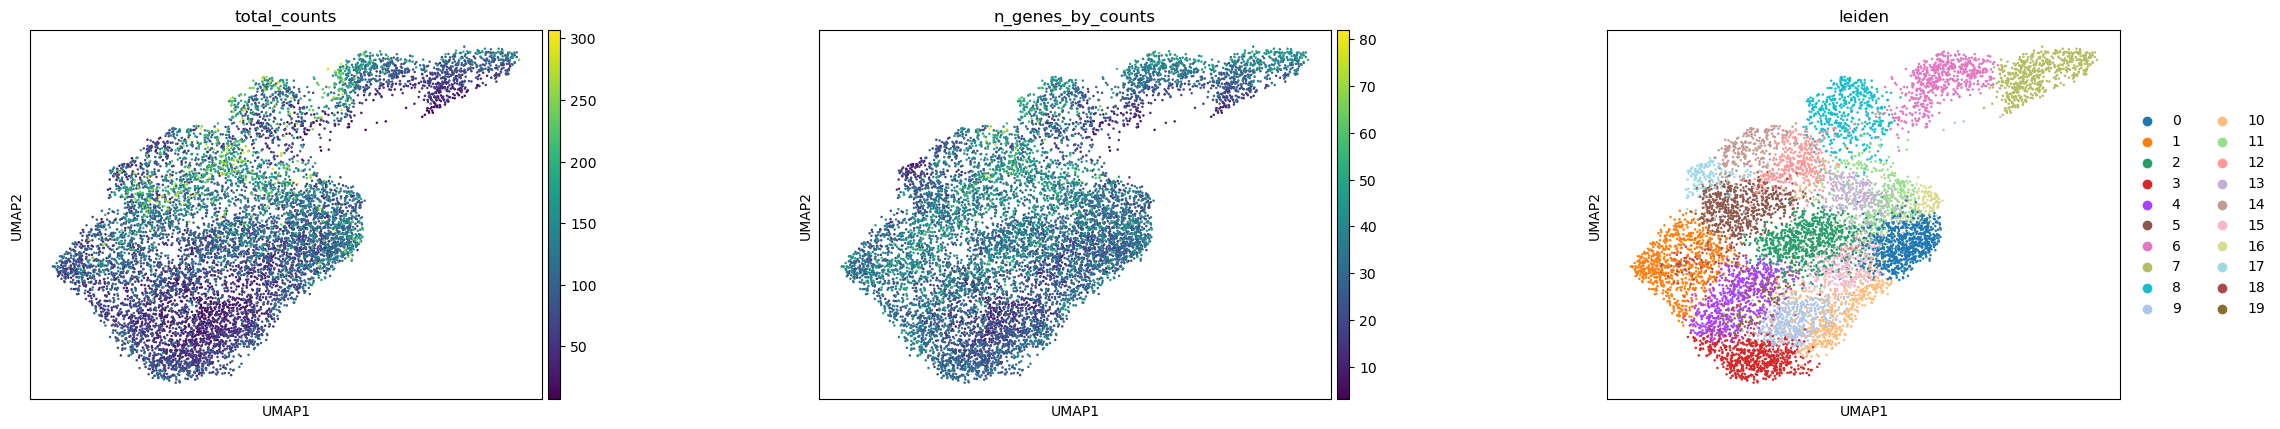

In [22]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

## Marker gene dotplot

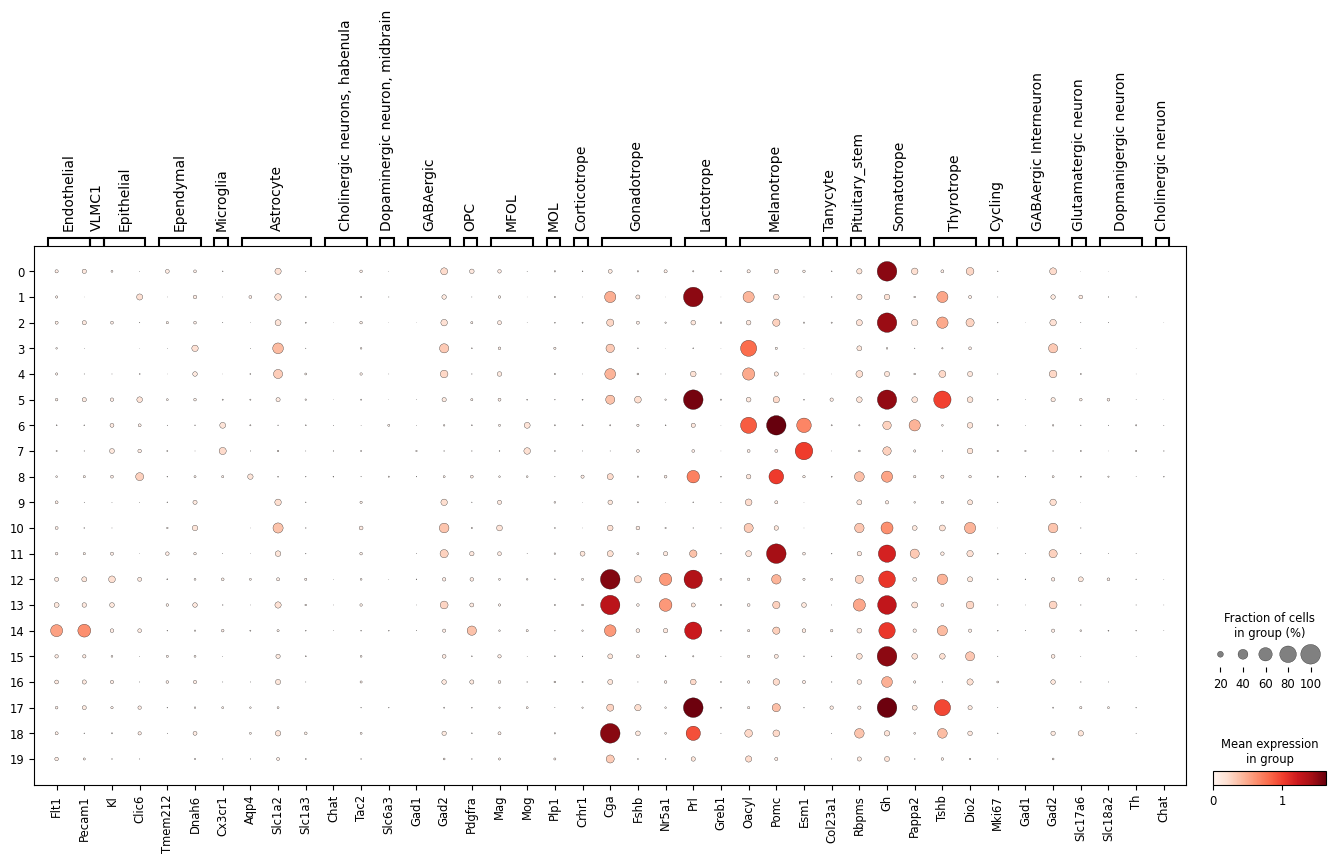

In [23]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

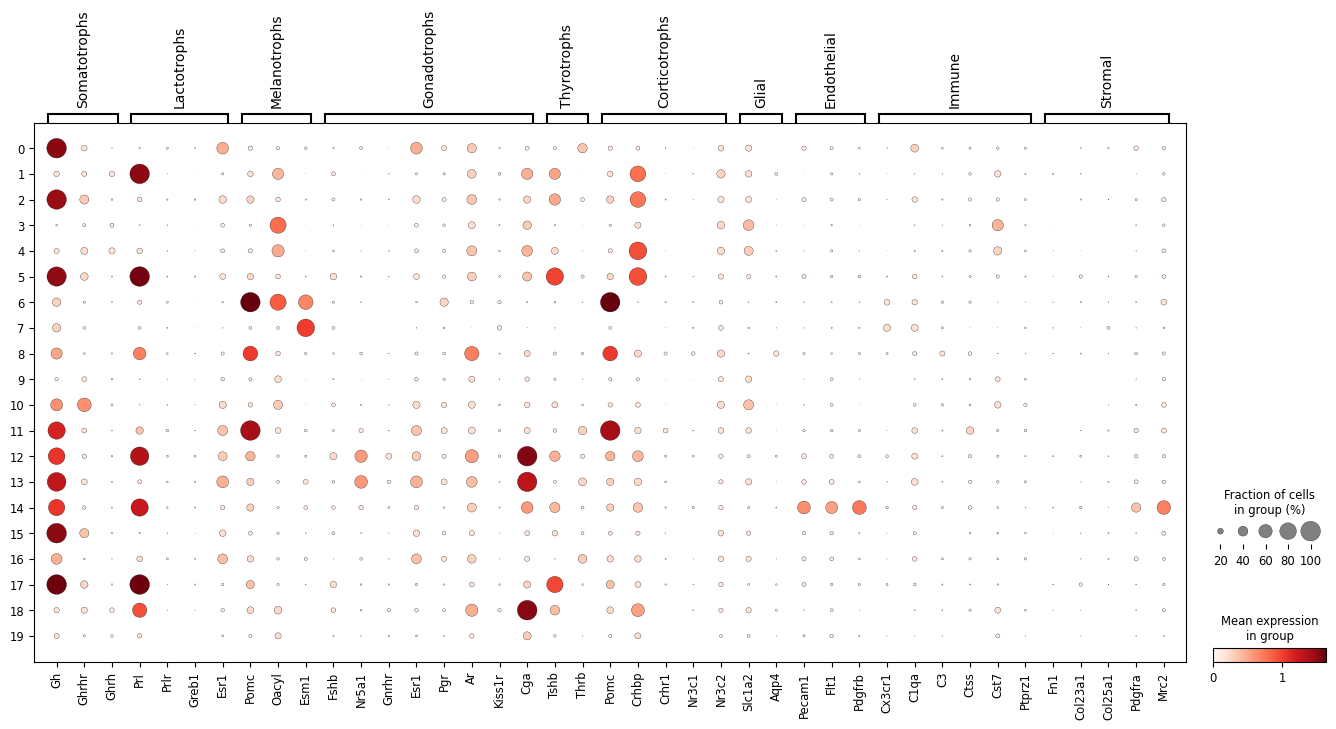

In [74]:
marker_dict ={ 
    "Somatotrophs":["Gh", "Ghrhr", "Ghrh"],
    "Lactotrophs": ["Prl","Prlr","Greb1","Esr1"], # overlapping expression with somato...
    "Melanotrophs": ["Pomc","Oacyl","Esm1"], #  Pomc is also expressed in corticotrophs 
    "Gonadotrophs":["Fshb","Nr5a1","Gnrhr","Esr1","Pgr","Ar","Kiss1r","Cga"], 
    "Thyrotrophs": ["Tshb","Thrb"], # small cluster(s)...
    "Corticotrophs": ["Pomc","Crhbp","Crhr1","Nr3c1","Nr3c2"], # Pomc+ non-marginal zone?
    "Glial":["Slc1a2","Aqp4"],
    "Endothelial":["Pecam1","Flt1","Pdgfrb"],
    "Immune":["Cx3cr1","C1qa","C3","Ctss","Cst7","Ptprz1"],
    "Stromal":["Fn1","Col23a1","Col25a1","Pdgfra","Mrc2"],
    
}


sc.pl.dotplot(adata, 
              marker_dict,
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )


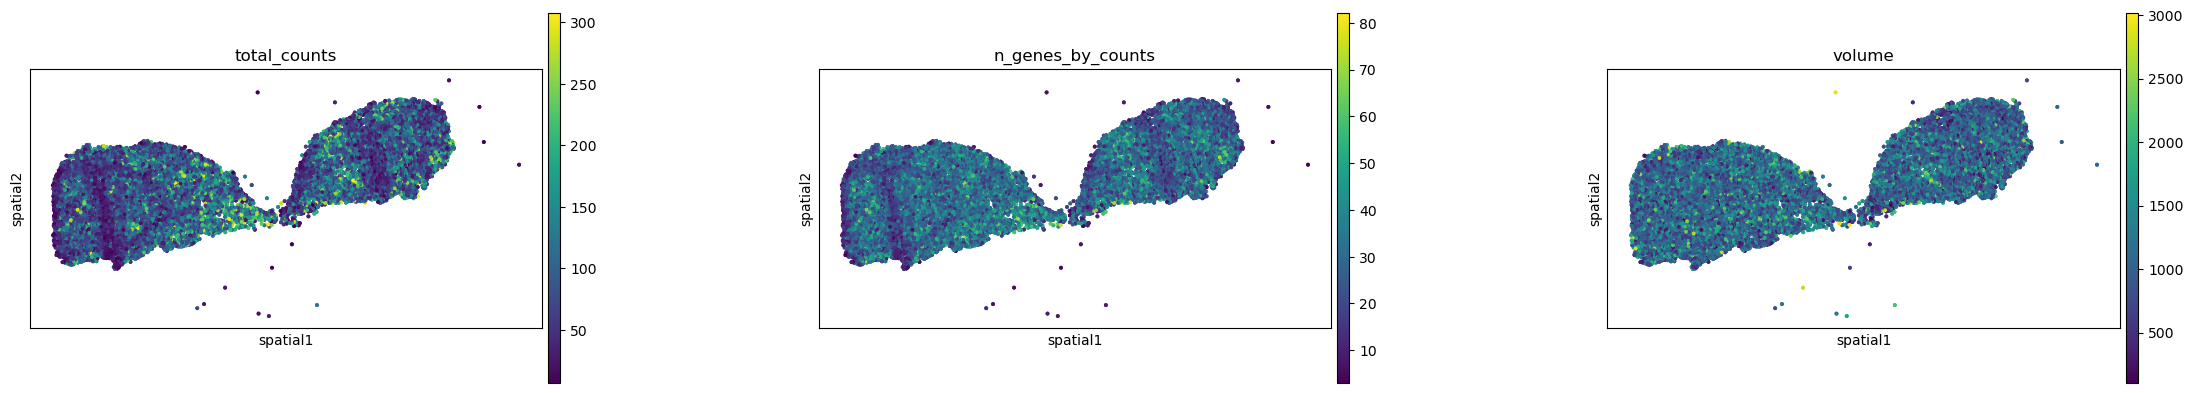

In [24]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "volume",
    ],
    wspace=0.4,
)

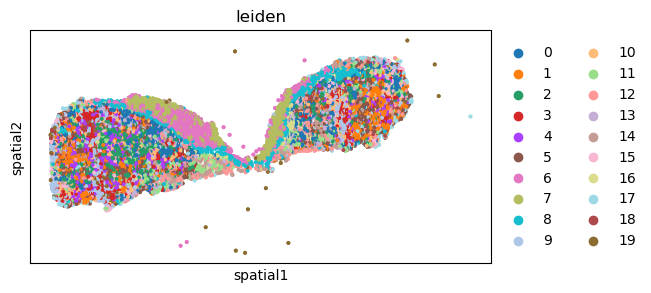

In [25]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## Highlight each cluster 

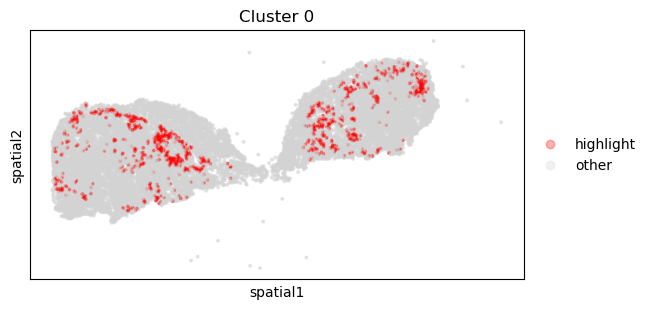

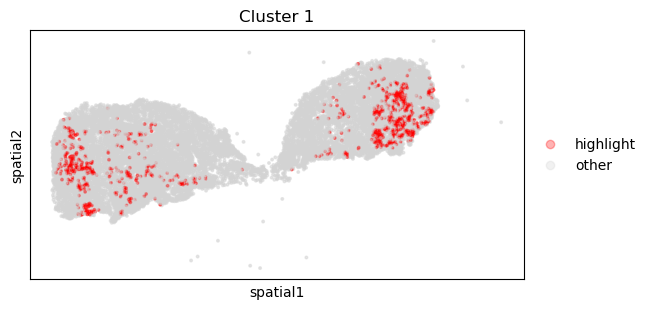

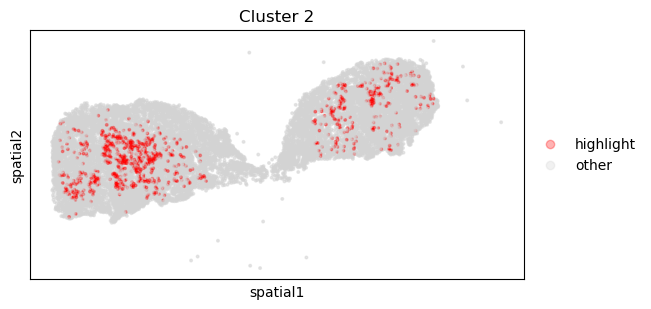

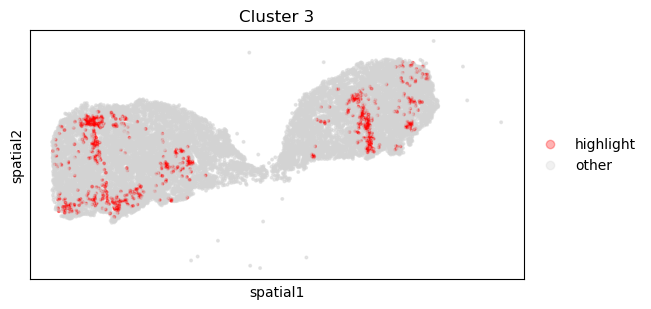

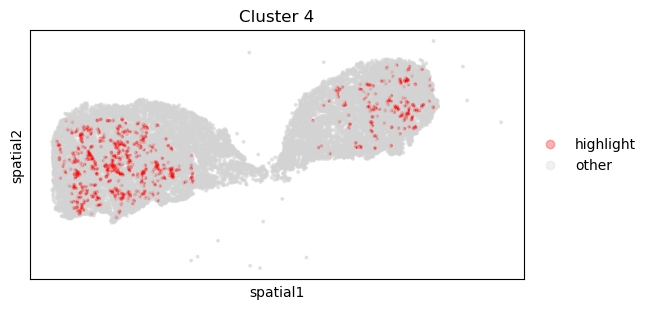

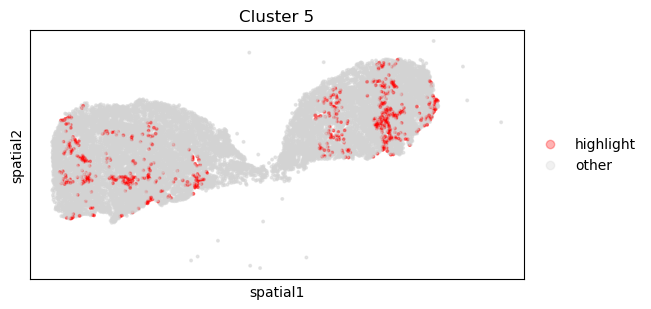

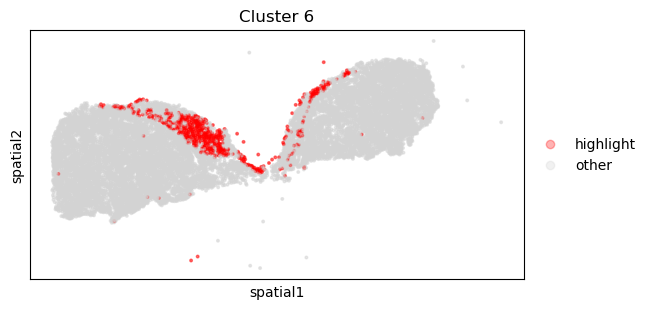

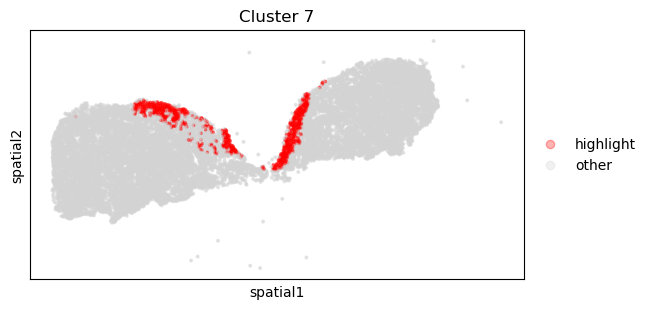

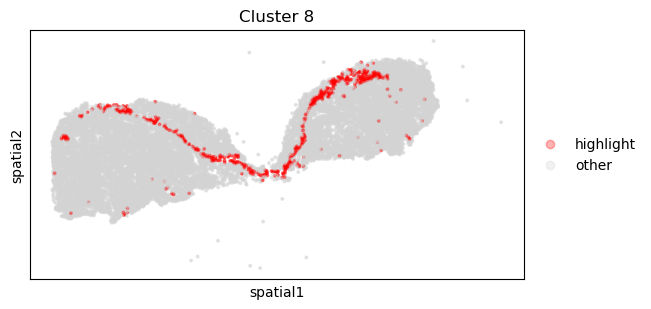

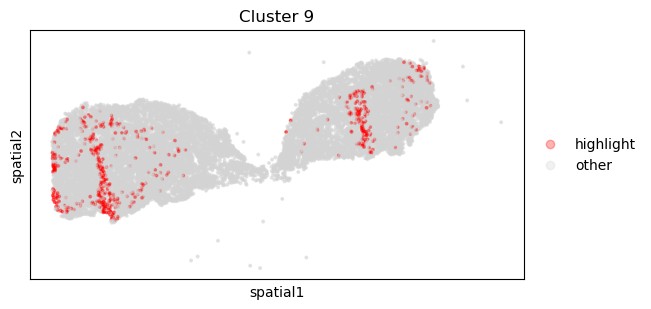

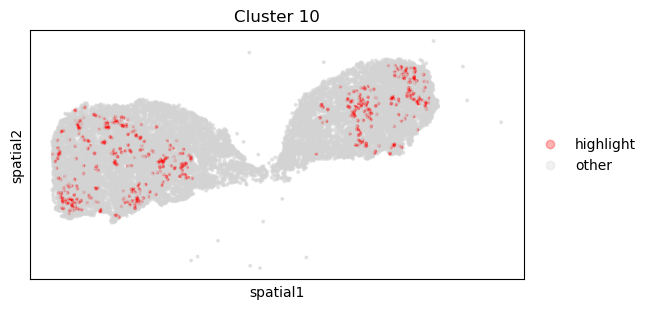

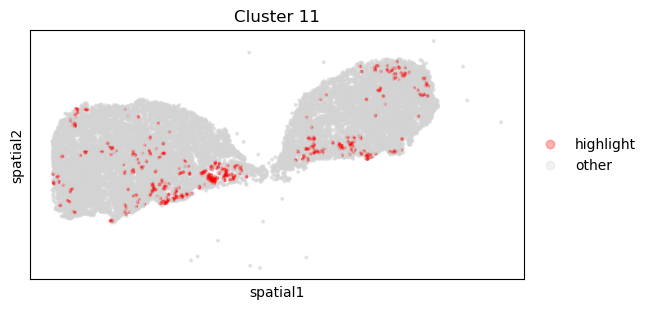

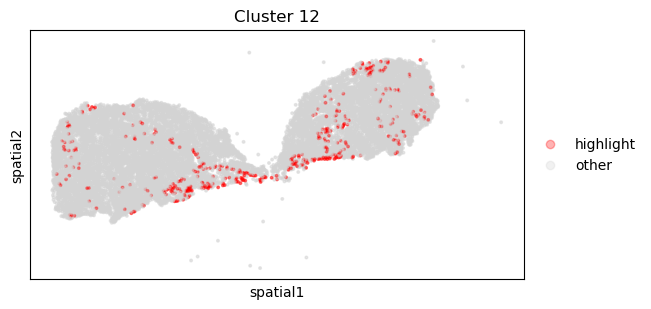

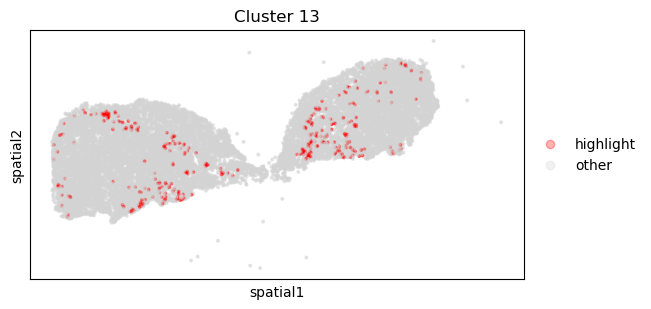

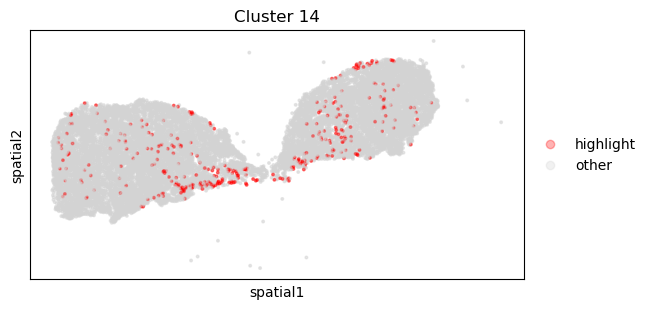

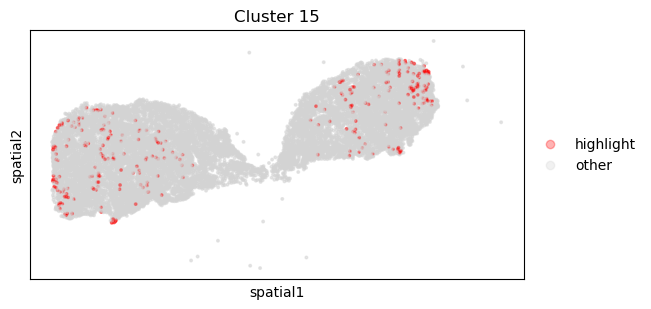

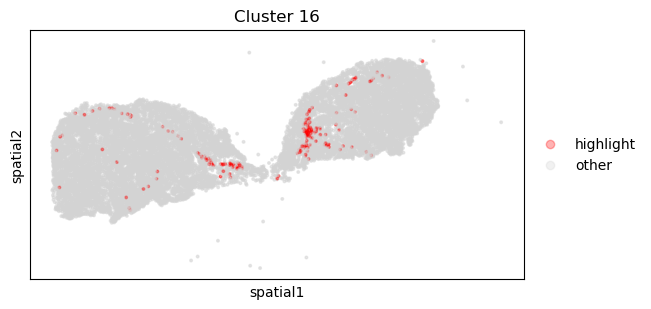

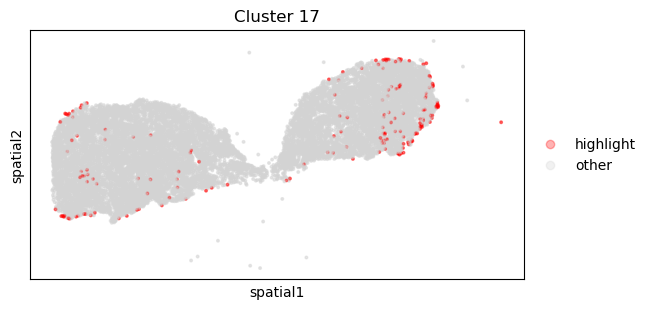

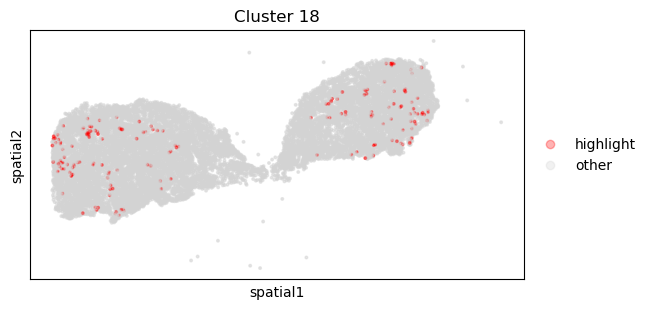

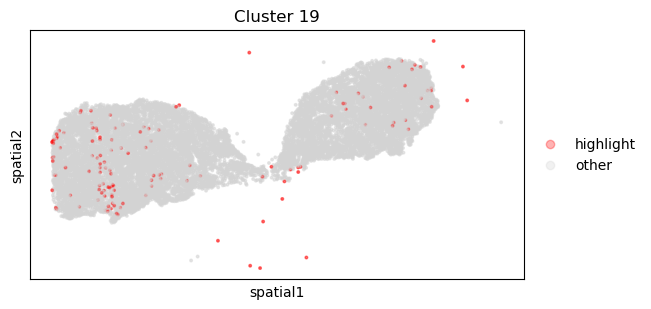

In [38]:
from matplotlib.colors import ListedColormap
import pandas as pd

# Get all unique leiden clusters
clusters = sorted(adata.obs["leiden"].unique(), key=int)

for cluster in clusters:
    adata.obs["highlight"] = pd.Categorical(
        adata.obs["leiden"].astype(str).apply(
            lambda x: "highlight" if x == cluster else "other"
        ),
        categories=["highlight", "other"]
    )

    custom_palette = ListedColormap(["red", "lightgrey"])

    sq.pl.spatial_scatter(
        adata,
        shape=None,
        color="highlight",
        palette=custom_palette,
        wspace=0.4,
        alpha=0.3,
        title=f"Cluster {cluster}",
    )


## Calculate markers

In [27]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")


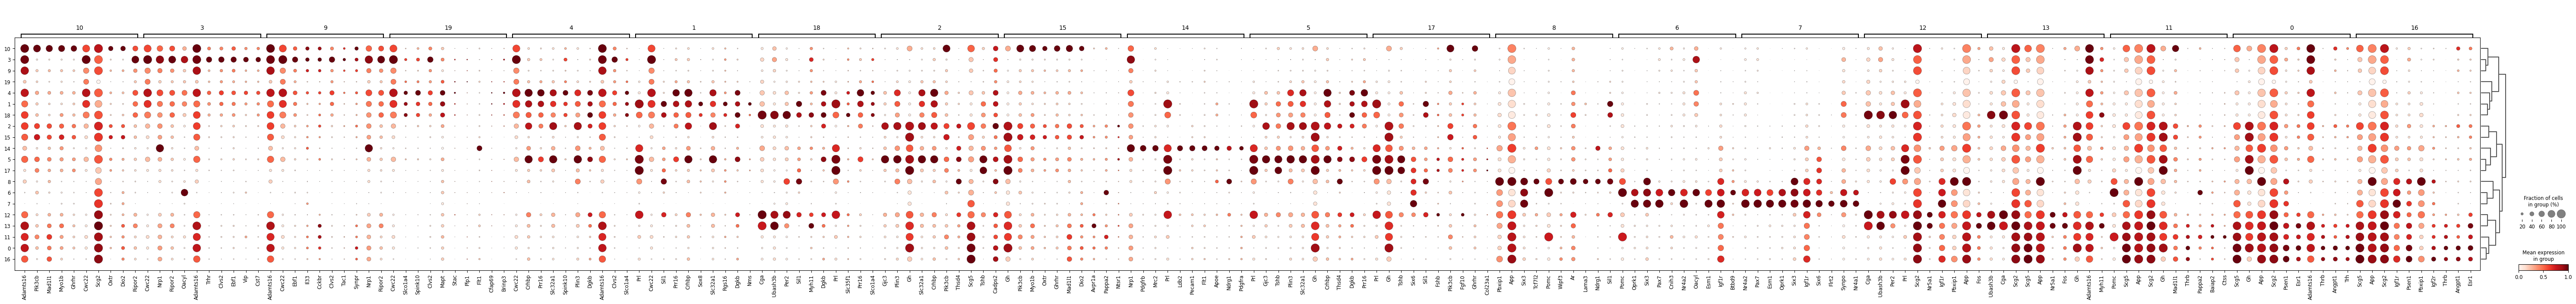

In [28]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=10
)

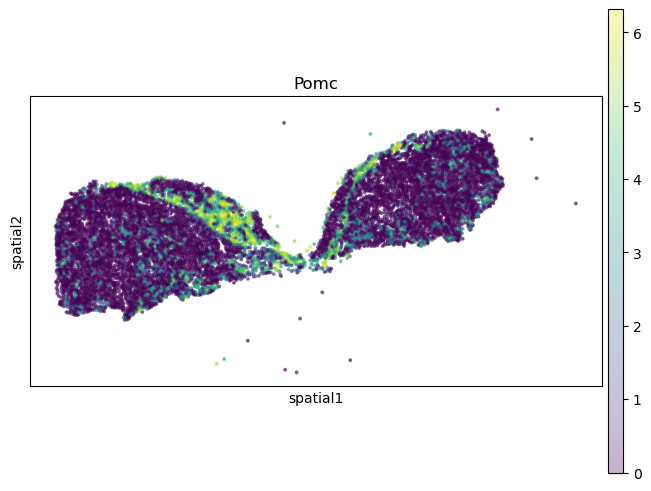

In [37]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Pomc"], # Melanotrope marker
    wspace=0.4,
    alpha=0.3, 
)

[<Axes: ylabel='n_genes_by_counts'>, <Axes: ylabel='total_counts'>]

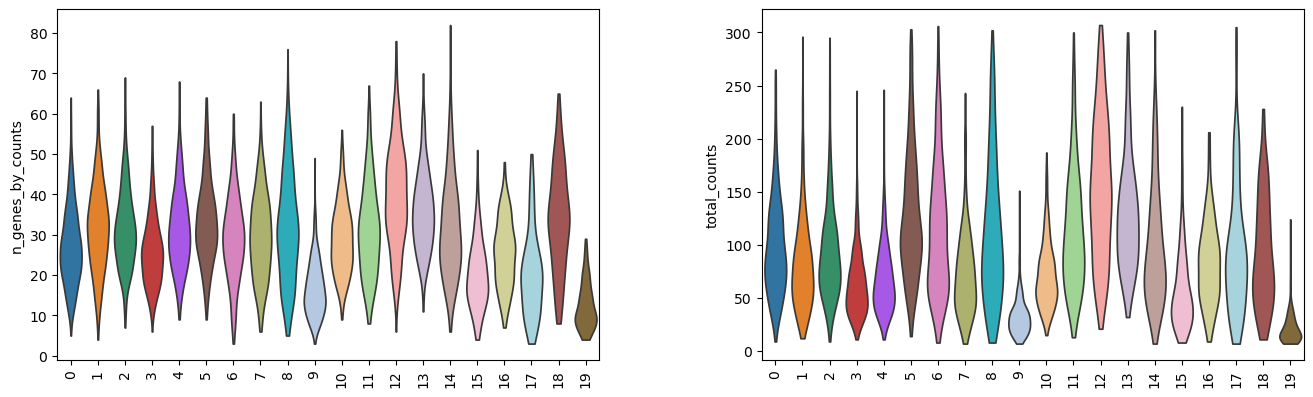

In [30]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='leiden',
    size=0,
    rotation = 90,
    multi_panel=True,
    show = False
)

## Assign celltypes

In [63]:
leiden_to_celltype = {
    '0':  'somatotroph',  # Gh+, Scg5+, Psen1+..
    '1':  'lactotroph', # Prl+, some Sox8, Sil1
    '2':  'somatotroph',  # Gh+, ...not really any specific markers, looks kinda like 5...except Prl-
    '3':  'unknown', # Oacyl+, specific markers include Trhr, Clvs2, Ebf1, Vip, Cst7
    '4':  'unknown', # Oacyl+, also Crhbp+, Prr16+, 
    '5':  'thyrotroph', # Prl+, Gh+, Tshb+, Crhbp+. Called marers include Gjc3, Plin3, Slc32a1
    '6':  'melanotroph', # MZ. Pomc++, Oacyl, Esm1+
    '7':  'melanotroph', # MZ. Esm1+
    '8':  'melanotroph', # MZ. most inner layer...Prl+, Pomc+
    '9':  'low quality', # no troph markers nor any of the other markres you gave...cluster markres are Ripor2, Cwc22, Ebf1, Adamts16 (not specific marker but strongly expressed) 
    '10': 'somatotroph', # faint Gh, top markers called: Pik3cb, Mad1l1, Myo1b, OXtr, Ghrhr, Mad1l1, Dio2
    '11': 'corticotroph', # Pomc++, Gh+...maybe cortico? Has very faint Crhr1..markers include Ctss, Baiap2 (ssubset of cells incluster though). Strongly expresses Scg5, Scg2, App 
    '12': 'gonadotroph', # Cga+, Prl+, Gh+, Ubash3b+, Per2+, Nr5a1+ along with cluster 13. 12 and 13 have strongest expression of Nr5a1. Also has some Fos
    '13': 'gonadotroph', #similar to 12 but Prl-. Weirdly Myh11+.
    '14': 'endothelial', # Flt1+ and Pecam1+ (slight), Mrc2+ slight, Prl+ and Gh+ again though as well! endothelial..?
    '15': 'somatotroph', # GH++. Shares hella markers with 10, xecept it's Gh++ and 10 is not.
    '16': 'unknown', # nothing very specific at all, looks  a lot like 0 but Gh- 
    '17': 'thyrotroph', #Prl++, Gh++, Tshb++, some Six6. Looks a lot like 5 but no Crhbp, Slc32a1, Plin3.
    '18': 'unknown', #Cga++ Prl+. Markers shared with 12 and 13 -- Ubash3b+, Per2+. 
    '19': 'low quality', # none honestly low quality like no strong expression of anyrhing, even markers are weak
}

# Adamts16 highly expresed in 10, 3, 9, 4, 18, 1, 2, 15, 5, 12, 13, 11, 0, 16
# Gh in 0, 2, 5, 11, 12, 13, 14, 15, 17
# Prl in 1, 5, 12, 14, 17, kinda 18
# Cga in 12, 13, 18
# Pomc in 6, 11,kinda 8
# Tshb in 5 and 17

# Add the annotation to your adata.obs
adata.obs['celltype'] = adata.obs['leiden'].map(leiden_to_celltype).astype('category')


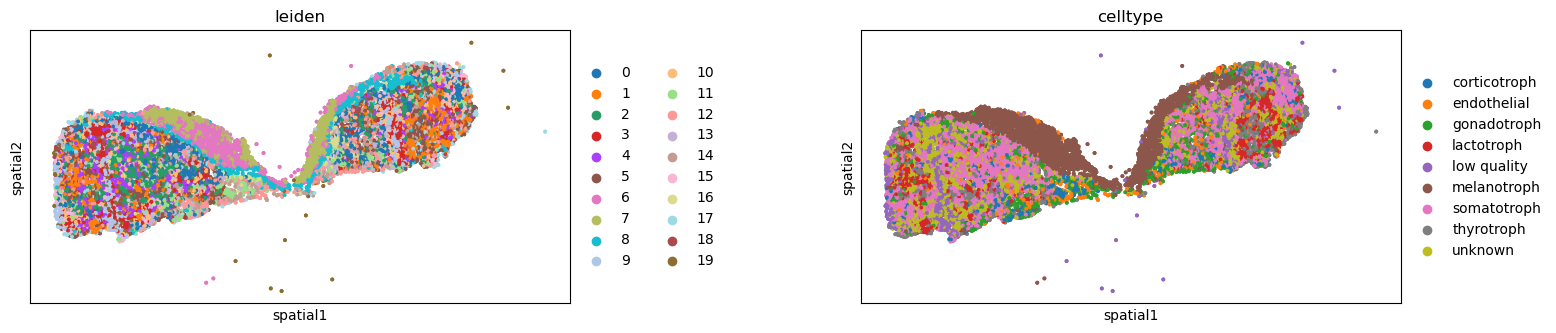

In [65]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["leiden","celltype"],
    wspace=0.4,
    #alpha=0.3, 
)

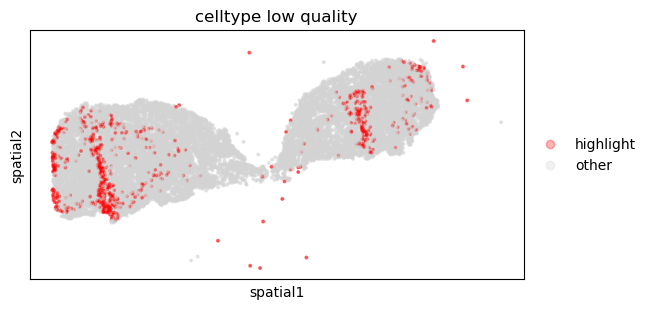

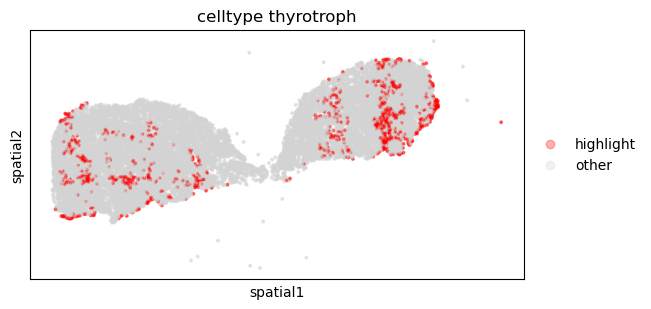

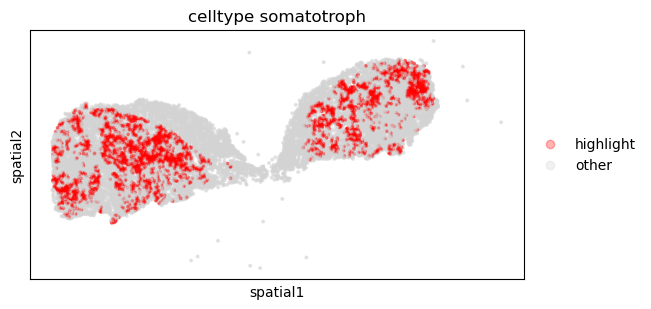

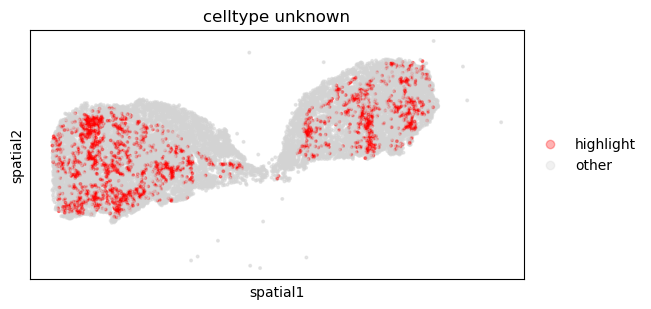

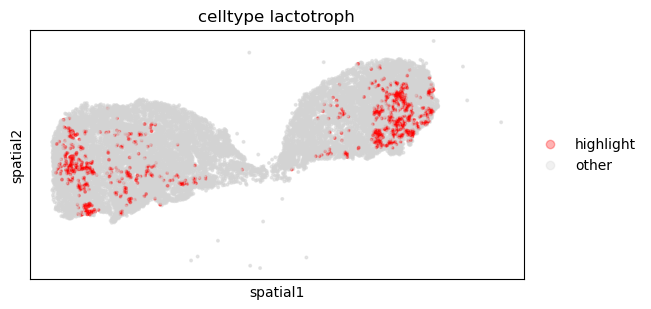

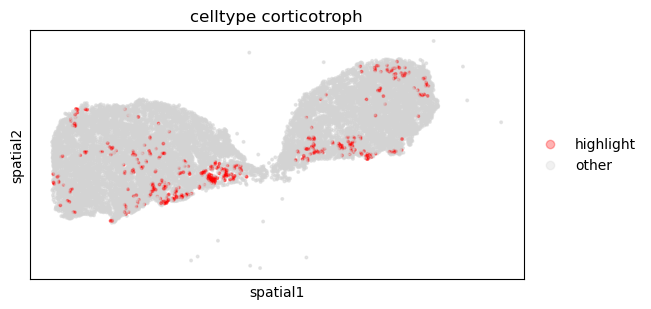

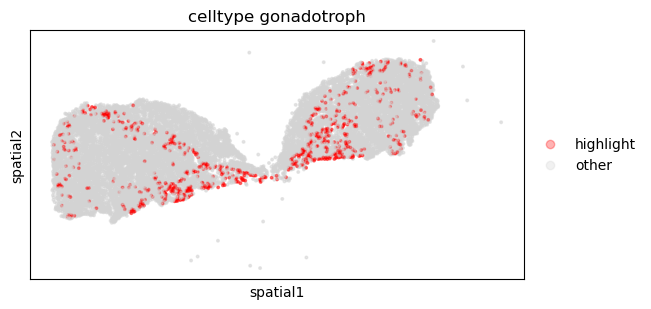

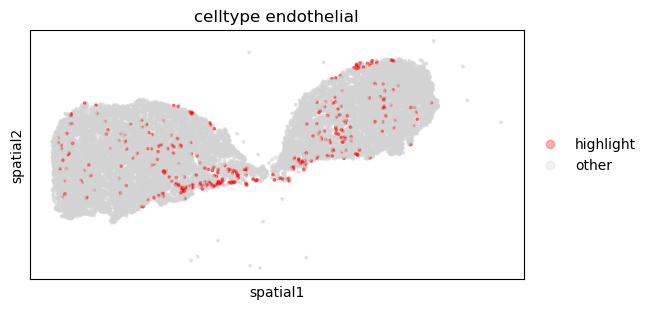

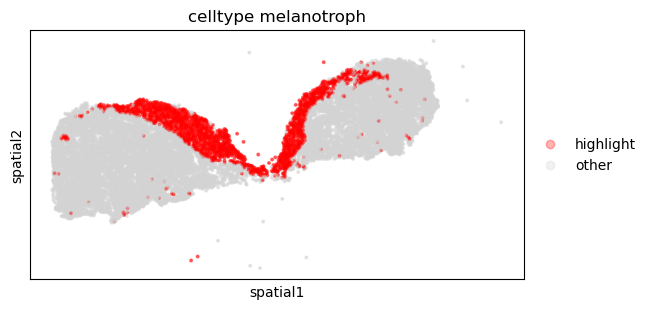

In [67]:
from matplotlib.colors import ListedColormap

celltypes = adata.obs["celltype"].unique()

for celltype in celltypes:
    adata.obs["highlight"] = pd.Categorical(
        adata.obs["celltype"].astype(str).apply(
            lambda x: "highlight" if x == celltype else "other"
        ),
        categories=["highlight", "other"]
    )

    custom_palette = ListedColormap(["red", "lightgrey"])

    sq.pl.spatial_scatter(
        adata,
        shape=None,
        color="highlight",
        palette=custom_palette,
        wspace=0.4,
        alpha=0.3,
        title=f"celltype {celltype}",
    )


# Calculate spatial neighbors

In [31]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)


In [32]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")


  0%|                                                  | 0/1000 [00:00<?, ?/s]/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 111.17/s]


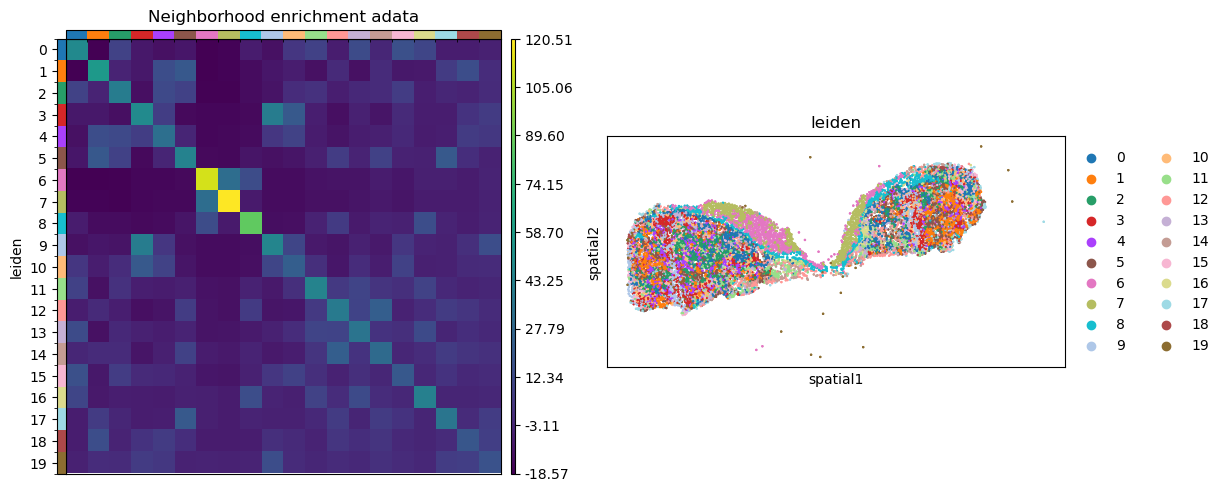

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

In [68]:
adata_filt = adata[adata.obs['celltype'] != 'low quality'].copy()

In [69]:
sq.gr.nhood_enrichment(adata_filt, cluster_key="celltype")


  0%|                                                                                 | 0/1000 [00:00<?, ?/s]/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.25/s]


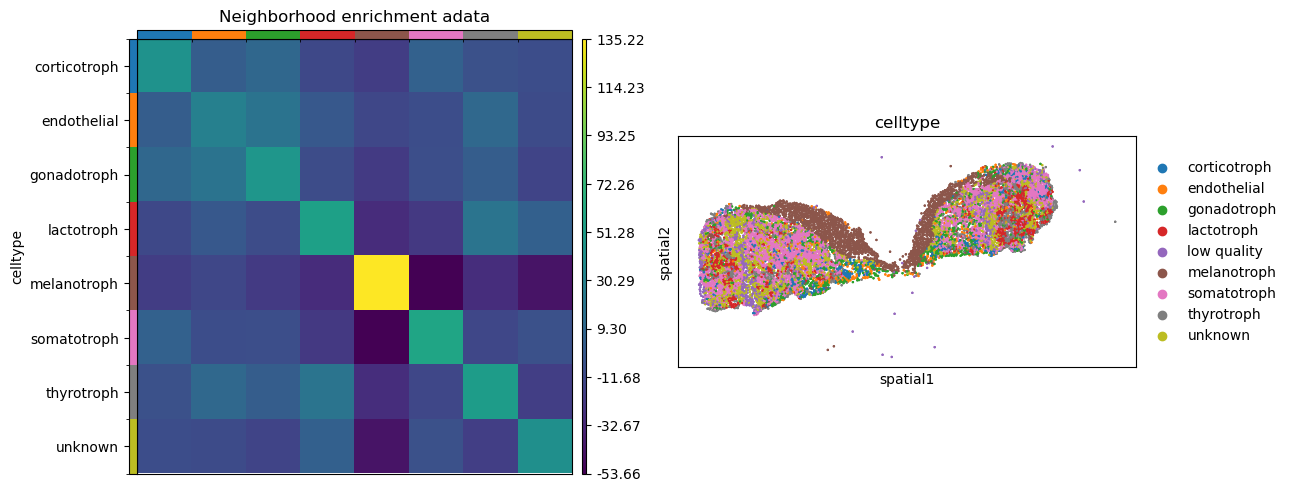

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata_filt,
    cluster_key="celltype",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="celltype", shape=None, size=2, ax=ax[1])

In [71]:
sq.gr.centrality_scores(adata, cluster_key="celltype")


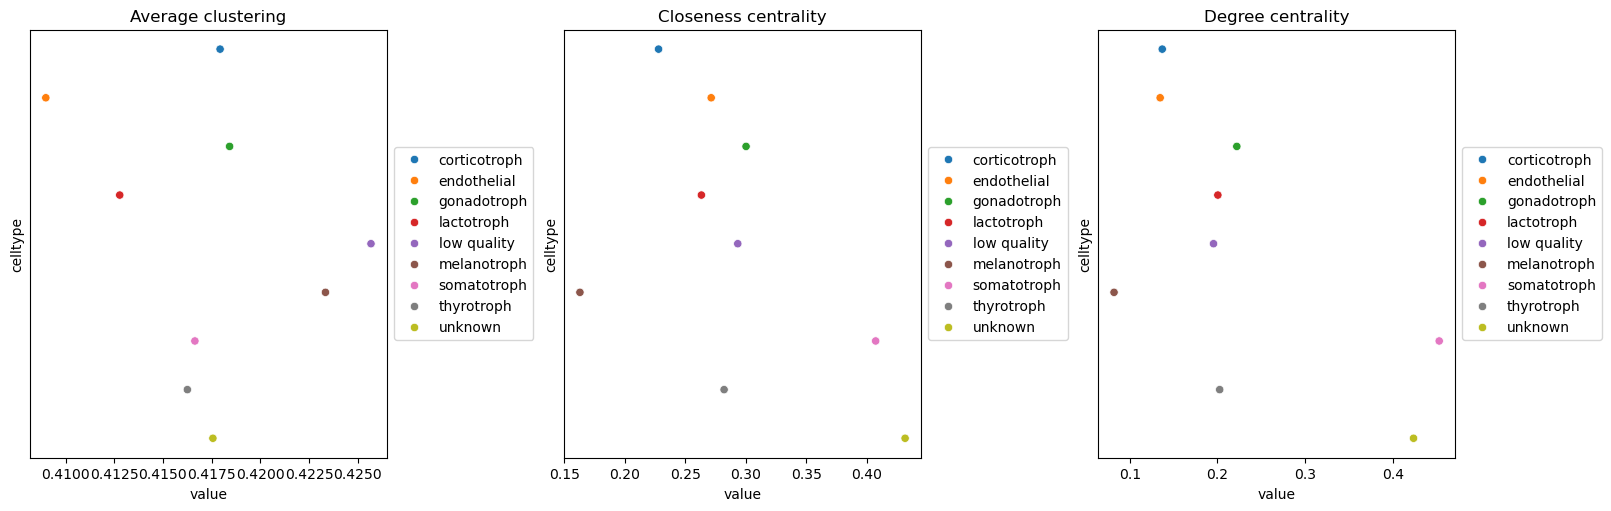

In [72]:
sq.pl.centrality_scores(adata, cluster_key="celltype", figsize=(16, 5))


# Save

In [34]:
adata.write_h5ad(f"pilot_data/region_{region}/region_{region}_adata_processed.h5ad")